输出文件
=========

nsga3_hv_sp_history.csv
列为：gen, hv, sp, front_size（front_size 是每代种群的前沿点数）

nsga3_front_solutions.csv：每行一个帕累托解（收益/回撤/得分/持仓数/Sharpe_Proxy）

nsga3_front_holdings.csv：每行一条持仓（solution_id, stock_code, industry, factor_score）

nsga3_front_quality_metrics.csv：HV、SP、front_size 等汇总

nsga3_holdings_max_return.csv

nsga3_holdings_max_score.csv

nsga3_holdings_min_risk.csv

nsga3_holdings_sharpe.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import random

# 忽略潜在的警告|
warnings.filterwarnings('ignore')


# ==========================================
# 第一部分：数据加载与预处理 (Data Preprocessing)
# 功能：读取CSV，过滤时间窗口，对齐数据，将行业转为数字编码
# ==========================================
def load_and_process_data():
    print("【步骤1】正在读取并处理数据...")

    # --- 1. 读取日收益率数据 (源头修复：指定 code 为字符串) ---
    try:
        # dtype={'code': str} 确保 '000001' 读进来还是 '000001'
        df_ret = pd.read_csv("data/stock_returns_daily.csv", dtype={'code': str})
    except FileNotFoundError:
        raise FileNotFoundError("缺失文件: stock_returns_daily.csv")

    df_ret['timestamps'] = pd.to_datetime(df_ret['timestamps'])

    # 过滤时间范围 (2024-12-02 到 2025-12-26)
    start_date = "2022-01-01"
    end_date = "2025-12-26"
    mask = (df_ret['timestamps'] >= start_date) & (df_ret['timestamps'] <= end_date)
    df_ret = df_ret.loc[mask]

    # --- 关键修复：ChangePCT 是百分数(%) -> 小数比率 ---
    df_ret["ChangePCT"] = pd.to_numeric(df_ret["ChangePCT"], errors="coerce") / 100.0

    # --- 学术更稳：极端/不可能值直接置空，不参与当日等权 ---
    # r <= -100% 会导致 (1+r)<=0，净值穿0；属于数据异常/口径异常
    df_ret.loc[df_ret["ChangePCT"] <= -0.999999, "ChangePCT"] = np.nan

    # 转换为矩阵：行=日期，列=股票代码
    df_ret['code'] = df_ret['code'].astype(str)
    returns_matrix = df_ret.pivot(index='timestamps', columns='code', values='ChangePCT')
    returns_matrix = returns_matrix.fillna(0.0)  # 填充缺失数据

    # --- 2. 读取因子得分数据 (源头修复) ---
    try:
        df_scores = pd.read_csv("data/csi300_3factor_scores_winsorized.csv", dtype={'code': str})
    except FileNotFoundError:
        raise FileNotFoundError("缺失文件: csi300_3factor_scores_winsorized.csv")

    df_scores['code'] = df_scores['code'].astype(str)
    df_scores = df_scores.drop_duplicates(subset=['code']).set_index('code')

    # --- 3. 读取行业分类数据 (源头修复) ---
    try:
        df_industry = pd.read_csv("data/csi300_with_industry_2022_2025.csv", dtype={'code': str})
    except FileNotFoundError:
        raise FileNotFoundError("缺失文件: csi300_with_industry_2022_2025.csv")

    df_industry['code'] = df_industry['code'].astype(str)
    df_industry = df_industry.drop_duplicates(subset=['code']).set_index('code')

    # 保存一份代码到名称的映射，方便后续展示
    # (如果有 name 列的话)
    if 'name' in df_industry.columns:
        code_to_name = df_industry['name'].to_dict()
    else:
        code_to_name = {}

    # 4. 数据对齐 (取三者交集)
    valid_codes = returns_matrix.columns
    valid_codes = valid_codes.intersection(df_scores.index)
    valid_codes = valid_codes.intersection(df_industry.index)

    print(f"   - 时间范围: {start_date} 至 {end_date}")
    print(f"   - 有效股票数量: {len(valid_codes)}")

    # 提取最终数据
    returns_matrix = returns_matrix[valid_codes]
    scores_series = df_scores.loc[valid_codes, 'final_score']
    industry_raw = df_industry.loc[valid_codes, 'sw_level1']

    # 将行业名称映射为整数 ID (0, 1, 2...)
    industry_codes, industry_uniques = pd.factorize(industry_raw)
    sectors_series = pd.Series(industry_codes, index=valid_codes)

    print(f"   - 覆盖行业数量: {len(industry_uniques)}")

    return returns_matrix, scores_series, sectors_series, valid_codes, industry_uniques, code_to_name


# ================================
# 【新增】Pareto/HV/SP 工具函数
# ================================
def nondominated_mask(min_objs: np.ndarray) -> np.ndarray:
    """
    min_objs: (M, d) 全部目标均为“越小越好”
    返回: (M,) True 表示非支配解
    """
    M = min_objs.shape[0]
    mask = np.ones(M, dtype=bool)
    for i in range(M):
        if not mask[i]:
            continue
        dominates_i = np.all(min_objs <= min_objs[i], axis=1) & np.any(min_objs < min_objs[i], axis=1)
        dominates_i[i] = False
        if np.any(dominates_i):
            mask[i] = False
    return mask


def normalize_to_unit_box(X: np.ndarray, eps: float = 1e-12):
    x_min = np.min(X, axis=0)
    x_max = np.max(X, axis=0)
    denom = np.maximum(x_max - x_min, eps)
    Xn = (X - x_min) / denom
    return Xn, x_min, x_max


def spacing_metric(front_norm: np.ndarray) -> float:
    K = front_norm.shape[0]
    if K < 2:
        return 0.0
    diffs = front_norm[:, None, :] - front_norm[None, :, :]
    dist = np.sqrt(np.sum(diffs * diffs, axis=2))
    np.fill_diagonal(dist, np.inf)
    d_i = np.min(dist, axis=1)
    d_mean = np.mean(d_i)
    return float(np.sqrt(np.sum((d_i - d_mean) ** 2) / (K - 1)))


def hypervolume_mc(front_norm_min: np.ndarray, ref: np.ndarray, n_samples: int = 20000, seed: int = 42) -> float:
    """
    Monte Carlo 估计 HV（越大越好）
    front_norm_min: 已归一化，且全最小化（越小越好）
    ref: 参考点（应比 front 更差），例如 [1.1, 1.1, 1.1]
    """
    rng = np.random.default_rng(seed)
    d = front_norm_min.shape[1]
    samples = rng.random((n_samples, d)) * ref
    dominated = np.any(np.all(front_norm_min[None, :, :] <= samples[:, None, :], axis=2), axis=1)
    return float(dominated.mean() * np.prod(ref))


# ==========================================
# 第二部分：算法配置 (Configuration)
# 功能：定义超参数、约束条件及参考点生成逻辑
# ==========================================
class Config:
    # 【新增】固定归一化基准配置
    BASELINE_SAMPLES = 10000  # 建议 5k~20k；越大越稳但更慢
    BASELINE_SEED = 14

    # 【新增】HV/SP 计算配置
    HV_REF = np.array([1.1, 1.1, 1.1])  # 归一化后参考点（越大越“差”）
    HV_SAMPLES = 100000  # Monte Carlo 采样数（越大越稳，但更慢）
    HV_SEED = 42  # 固定随机种子，便于复现实验曲线

    # 进化参数
    N_POP = 100  # 种群规模
    N_GEN = 200  # 迭代代数 (建议 100-200)
    PC = 0.9  # 交叉概率
    PM = 0.05  # 变异概率

    # 约束条件
    K_MIN = 10  # 最小持仓数
    K_MAX = 30  # 最大持仓数
    MIN_SECTORS = 5  # 最小行业覆盖数
    MAX_SECTOR_RATIO = 0.25  # 单行业占比上限 (25%)

    # --- 学术更稳：组合日收益的有效覆盖率阈值 ---
    # 例如 0.8 表示：每天至少 80% 的持仓股票需要有收益数据，否则该组合判无效（惩罚）
    MIN_VALID_RATIO = 0.80

    # --- 学术更稳：Winsorize 日收益，防止极端点主导目标（可选） ---
    # 例如限制在 [-20%, +20%]，你也可以根据市场环境调整
    RET_CLIP = (-0.20, 0.20)

    # 目标函数参数
    TRADING_DAYS = 250  # 年化系数

    # 权重配置 (用于距离计算)
    # 顺序: [年化收益, 最大回撤, 因子得分]
    W_DIST = np.array([0.3, 0.4, 0.3])


# ==========================================
# 第三部分：核心算法实现 (NSGA-III Core)
# 功能：实现目标计算、修复算子、交叉变异及选择逻辑
# ==========================================
class NSGA3_Optimizer:
    def __init__(self, returns, scores, sectors):
        self.returns = returns.values  # (T, N)
        self.scores = scores.values  # (N,)
        self.sectors = sectors.values  # (N,)
        self.n_stocks = len(scores)

        # 生成风险分层参考点
        self.ref_points = self._generate_risk_stratified_refs()

        # 记录历史 (保留您的CSV输出需求)
        self.hv_sp_history = []

        # 【新增】基因保护机制相关
        # protected_mask[i, j] = True 表示第 i 个个体的第 j 只股票是“优质核心”，需保护
        self.protected_masks = np.zeros((Config.N_POP, self.n_stocks), dtype=bool)
        self.window_size = 5  # 滑动窗口大小 (5只股票)
        self.protect_freq = 10  # 每10代更新一次保护名单

        # 【新增】计算个股质量分级 (0:劣质, 1:普通, 2:优质)
        # 这一步只在初始化做一次，不影响迭代速度
        self.stock_tiers = self._calculate_stock_quality_tiers()

        # 【新增】全局测量基准 (防止 HV 剧烈抖动)
        # 初始设为无穷大/无穷小，后续动态更新
        self.global_min_objs = np.full(3, np.inf)
        self.global_max_objs = np.full(3, -np.inf)

    def _calculate_stock_quality_tiers(self):
        """
        【新增】基于因子分和波动率，给股票分级
        Tier 2 (Elite): 高分低波 (前 30%)
        Tier 0 (Weak):  低分高波 (后 30%)
        Tier 1 (Mid):   中间 (40%)
        """
        # 1. 计算个股历史波动率 (风险代理)
        # axis=0 对时间维度求标准差
        volatility = np.nanstd(self.returns, axis=0)
        # 填充 nan (防止报错)
        volatility[np.isnan(volatility)] = np.nanmean(volatility)

        # 2. 归一化 (越小越好 -> 转为越大越好)
        # 分数归一化 (0-1)
        s_min, s_max = np.min(self.scores), np.max(self.scores)
        norm_score = (self.scores - s_min) / (s_max - s_min + 1e-9)

        # 波动率归一化 (0-1)，注意：波动率越小越好，所以取反
        v_min, v_max = np.min(volatility), np.max(volatility)
        norm_vol = 1 - (volatility - v_min) / (v_max - v_min + 1e-9)

        # 3. 综合质量分 = 0.7 * 因子分 + 0.3 * 低波分
        # (权重可调，假设我们更看重因子)
        quality_score = 0.7 * norm_score + 0.3 * norm_vol

        # 4. 分位数分级
        tiers = np.ones(self.n_stocks, dtype=int)  # 默认为 1 (普通)

        th_high = np.percentile(quality_score, 70)  # Top 30%
        th_low = np.percentile(quality_score, 30)  # Bottom 30%

        tiers[quality_score >= th_high] = 2  # 优质
        tiers[quality_score <= th_low] = 0  # 劣质

        print(f"  [Stock Quality] Elite: {np.sum(tiers == 2)}, Mid: {np.sum(tiers == 1)}, Weak: {np.sum(tiers == 0)}")
        return tiers

    def _generate_risk_stratified_refs(self):
        """生成30个风险分层参考点"""
        """
        【改进】混合参考点：偏好点 + 均匀点 + 边界点
        作用：填补解集空隙，提升 SP；拉伸边界，提升 HV
        """
        refs = []

        # 1. 业务偏好点 (保持原有逻辑，占约 40%)
        # 保守
        for _ in range(12):
            r = np.array([0.2, 0.6, 0.2]) + np.random.rand(3) * 0.05
            refs.append(r / r.sum())
        # 平衡
        for _ in range(12):
            r = np.array([0.33, 0.33, 0.33]) + np.random.rand(3) * 0.05
            refs.append(r / r.sum())
        # 激进
        for _ in range(6):
            if np.random.rand() > 0.5:
                r = np.array([0.6, 0.1, 0.3])
            else:
                r = np.array([0.3, 0.1, 0.6])
            refs.append(r / r.sum())

        # 2. 【新增】均匀随机点 (占约 50%)
        # 填补偏好点之间的“无人区”，让前沿连成一条线
        n_uniform = 40
        for _ in range(n_uniform):
            r = np.random.rand(3)
            refs.append(r / r.sum())

        # 3. 【新增】极端边界点 (Anchor Points)
        # 强行拉伸 HV 的边界
        refs.append(np.array([0.98, 0.01, 0.01]))  # 极度重收益
        refs.append(np.array([0.01, 0.98, 0.01]))  # 极度重风险
        refs.append(np.array([0.01, 0.01, 0.98]))  # 极度重得分

        return np.array(refs)

    def calculate_objectives(self, z):
        sel_idx = np.where(z == 1)[0]
        # 空解惩罚
        if len(sel_idx) == 0:
            return np.array([-999.0, 999.0, -999.0])

        # 1. 因子得分
        f_score = float(np.mean(self.scores[sel_idx]))

        # 2. 收益与回撤
        # 使用 nanmean 处理停牌/缺失数据
        sel_ret = self.returns[:, sel_idx]
        port_daily_ret = np.nanmean(sel_ret, axis=1)

        # 兜底检查
        if np.all(np.isnan(port_daily_ret)):
            return np.array([-999.0, 999.0, -999.0])

        # 净值计算 (Log累加更稳定)
        log_nav = np.cumsum(np.log1p(port_daily_ret))
        nav = np.exp(log_nav)

        # 年化收益
        ann_ret = nav[-1] ** (Config.TRADING_DAYS / len(nav)) - 1

        # 最大回撤
        peak = np.maximum.accumulate(nav)
        dd = (peak - nav) / peak
        max_dd = float(np.max(dd))

        return np.array([ann_ret, max_dd, f_score])

    def _calculate_window_metrics(self, indices):
        """
        【新增】计算种子窗口的指标 (局部评估)
        用于判断这 5-10 只股票组成的小组合是否足够优秀
        """
        f_score = float(np.mean(self.scores[indices]))

        sel_ret = self.returns[:, indices]
        port_daily_ret = np.nanmean(sel_ret, axis=1)

        # 简单计算年化收益和波动率 (作为风险代理，比回撤计算快)
        ann_ret = np.mean(port_daily_ret) * Config.TRADING_DAYS
        ann_vol = np.std(port_daily_ret) * np.sqrt(Config.TRADING_DAYS)

        # 返回: [收益, 风险(波动率), 得分]
        return ann_ret, ann_vol, f_score

    def update_protected_fragments(self, pop):
        """
        【新增】核心思想实现：识别并锁定优质片段
        步骤 1 & 3: 滑动窗口扫描，标记优质子集
        """
        # 重置保护掩码
        self.protected_masks = np.zeros((len(pop), self.n_stocks), dtype=bool)

        # 收集所有窗口的指标以确定相对阈值
        all_window_metrics = []
        window_mapping = []  # (pop_idx, stock_indices)

        for i, ind in enumerate(pop):
            sel_idx = np.where(ind == 1)[0]
            if len(sel_idx) < self.window_size:
                continue

            # 滑动窗口 (Step 1)
            # 假设 sel_idx 是 [0, 5, 12, ...]，窗口就是 [0,5,12,15,20]
            for start in range(len(sel_idx) - self.window_size + 1):
                window_indices = sel_idx[start: start + self.window_size]

                ret, vol, score = self._calculate_window_metrics(window_indices)
                all_window_metrics.append([ret, vol, score])
                window_mapping.append((i, window_indices))

        if not all_window_metrics:
            return

        # 确定动态阈值 (Top 20% 收益，Bottom 20% 风险，Top 20% 得分)
        # 只要满足其中两个条件，或者综合表现优异，即判定为“非支配窗口”
        metrics = np.array(all_window_metrics)

        th_ret = np.percentile(metrics[:, 0], 70)  # 收益前30%
        th_vol = np.percentile(metrics[:, 1], 40)  # 风险后40% (越小越好)
        th_score = np.percentile(metrics[:, 2], 60)  # 得分前40%

        # 筛选优质窗口
        count_protected = 0
        for idx, (ret, vol, score) in enumerate(metrics):
            # 判定逻辑：高收益低风险 OR 高收益高分 OR 低风险高分
            is_good = 0
            if ret > th_ret: is_good += 1
            if vol < th_vol: is_good += 1
            if score > th_score: is_good += 1

            if is_good >= 2:  # 满足两项及以上
                pop_idx, indices = window_mapping[idx]
                # 标记为保护 (Step 1 end)
                self.protected_masks[pop_idx, indices] = True
                count_protected += 1

        print(f"  [Gene Protection] Identified {count_protected} elite fragments across population.")

    def _crossover_with_protection(self, p1, p2, p1_idx, p2_idx, gen, max_gen):
        """
        【改进】带有保护机制的交叉算子
        步骤 2: 强制保留保护区域
        """
        # 1. 基础交叉 (均匀交叉或两点交叉)
        if np.random.rand() > Config.PC:
            child = p1.copy()
        else:
            # 均匀交叉
            mask = np.random.rand(self.n_stocks) < 0.5
            child = p1.copy()
            child[mask] = p2[mask]

        # 2. 【关键】强制覆盖受保护的基因 (Step 2)
        # 如果父本1在某位置有保护，子代必须继承父本1的该位置值
        mask1 = self.protected_masks[p1_idx]
        mask2 = self.protected_masks[p2_idx]

        # 逻辑：受保护的基因片段意味着“这个股票在这个组合里很好”，所以必须保留
        # 如果 p1 说要保，就用 p1 的；如果 p2 说要保，就用 p2 的
        # 如果两者都要保，通常它们的值都是 1（选中），所以冲突不大

        child[mask1] = p1[mask1]
        child[mask2] = p2[mask2]

        # 3. 【新增】生成子代的保护 Mask
        # 子代的保护区 = 父母保护区的并集 (只要父母任意一方说要保，子代就得保)
        child_mask = mask1 | mask2

        # 3. 修复 (传入 gen)
        return self.repair(child, child_mask, gen, max_gen), child_mask

    def _roulette_select(self, indices, n_select, current_gen=0, max_gen=100, is_add=True):
        """
        【改进】退火式贪婪选择
        前期(gen=0) epsilon较低(如0.5)，允许更多随机探索
        后期(gen=max) epsilon趋近1.0，强制锁定最优，减少波动
        """
        if len(indices) == 0: return []

        cand_scores = self.scores[indices]
        if is_add:
            sorted_args = np.argsort(cand_scores)[::-1]
        else:
            sorted_args = np.argsort(cand_scores)
        sorted_indices = indices[sorted_args]

        selected = []

        # 【动态 Epsilon】线性增长: 0.5 -> 0.95
        progress = current_gen / max(1, max_gen)
        epsilon = 0.5 + 0.45 * progress

        pool_size = max(1, min(len(sorted_indices), 5))

        for _ in range(n_select):
            if np.random.rand() < epsilon:
                # 贪婪模式
                choice = sorted_indices[0]
            else:
                # 随机模式
                # 再次防止越界
                curr_pool = min(pool_size, len(sorted_indices))
                choice = sorted_indices[np.random.randint(0, curr_pool)]

            selected.append(choice)
            # 移除已选
            sorted_indices = sorted_indices[sorted_indices != choice]
            if len(sorted_indices) == 0: break

        return np.array(selected)

    def repair(self, z, protected_mask=None, current_gen=0, max_gen=100):
        """
        【改进】感知保护机制的修复算子
        参数:
            z: 个体基因
            protected_mask: (可选) 布尔数组，True表示该位置受保护，不建议修改
        """
        z_new = z.copy()

        # 如果没有提供掩码，创建一个全 False 的
        if protected_mask is None:
            protected_mask = np.zeros(self.n_stocks, dtype=bool)

        # --- 1. 数量约束 (10-30) ---
        while True:
            k = int(np.sum(z_new))
            if k < Config.K_MIN:
                # 加仓：从没买的里面选
                candidates = np.where(z_new == 0)[0]
                if len(candidates) == 0: break
                to_add = self._roulette_select(candidates, 1, current_gen, max_gen, is_add=True)
                z_new[to_add] = 1

            elif k > Config.K_MAX:
                # 减仓：【关键修改】优先剔除“未受保护”的持仓
                # 只有当非保护持仓删光了，才被迫删保护持仓

                # 找出所有持仓
                held_indices = np.where(z_new == 1)[0]

                # 分成两类：受保护的 / 没受保护的
                unprotected_held = held_indices[~protected_mask[held_indices]]
                protected_held = held_indices[protected_mask[held_indices]]

                if len(unprotected_held) > 0:
                    # 优先在没保护的里面删
                    to_remove = self._roulette_select(unprotected_held, 1, current_gen, max_gen, is_add=False)
                else:
                    # 没办法，只能动保护的了 (极少发生)
                    to_remove = self._roulette_select(protected_held, 1, current_gen, max_gen, is_add=False)

                z_new[to_remove] = 0
            else:
                break

        # --- 2. 行业覆盖约束 ---
        # (逻辑同理：如果需要剔除平衡数量，优先剔除非保护的)
        sel_idx = np.where(z_new == 1)[0]
        curr_secs = np.unique(self.sectors[sel_idx])

        if len(curr_secs) < Config.MIN_SECTORS:
            missing = np.setdiff1d(np.unique(self.sectors), curr_secs)
            cand = np.where(np.isin(self.sectors, missing) & (z_new == 0))[0]

            if len(cand) > 0:
                n_need = Config.MIN_SECTORS - len(curr_secs)
                to_add = self._roulette_select(cand, n_need, current_gen, max_gen, is_add=True)
                z_new[to_add] = 1

                # 平衡数量
                if np.sum(z_new) > Config.K_MAX:
                    # 重新获取持仓
                    held_indices = np.where(z_new == 1)[0]
                    unprotected_held = held_indices[~protected_mask[held_indices]]
                    protected_held = held_indices[protected_mask[held_indices]]

                    n_del = np.sum(z_new) - Config.K_MAX

                    # 尝试从非保护中删除
                    if len(unprotected_held) >= n_del:
                        to_remove = self._roulette_select(unprotected_held, n_del, current_gen, max_gen, is_add=False)
                        z_new[to_remove] = 0
                    else:
                        # 混着删
                        z_new[unprotected_held] = 0  # 全删
                        rem_del = n_del - len(unprotected_held)
                        to_remove = self._roulette_select(protected_held, rem_del, current_gen, max_gen, is_add=False)
                        z_new[to_remove] = 0

        # 3. 行业占比
        sel_idx = np.where(z_new == 1)[0]
        k = len(sel_idx)
        unique_secs = np.unique(self.sectors[sel_idx])
        for s in unique_secs:
            cnt = np.sum(self.sectors[sel_idx] == s)
            max_allow = max(1, int(k * Config.MAX_SECTOR_RATIO))
            if cnt > max_allow:
                in_sec = sel_idx[self.sectors[sel_idx] == s]
                to_remove = self._roulette_select(in_sec, cnt - max_allow, is_add=False)
                z_new[to_remove] = 0

        # 兜底
        if np.sum(z_new) < Config.K_MIN:
            cand = np.where(z_new == 0)[0]
            to_add = self._roulette_select(cand, Config.K_MIN - np.sum(z_new), is_add=True)
            z_new[to_add] = 1

        return z_new

    def _crossover(self, p1, p2):
        if np.random.rand() > Config.PC: return p1.copy()
        pt1, pt2 = np.sort(np.random.randint(0, self.n_stocks, 2))
        child = p1.copy()
        child[pt1:pt2] = p2[pt1:pt2]
        return self.repair(child)

    def _adaptive_mutation_with_protection(self, z, gen, max_gen, protected_mask):
        """
        【改进】结合了自适应 + 保护机制的变异
        """
        z_mut = z.copy()
        progress = gen / max_gen
        current_base_pm = Config.PM * (1 - 0.5 * progress)

        for i in range(self.n_stocks):
            # 如果该基因位被保护，且当前已经持有(z=1)，强制跳过变异
            # 含义：这个好股票必须留着，不允许随机翻转成0
            if protected_mask[i] and z[i] == 1:
                continue

            # 原有的质量导向逻辑
            tier = self.stock_tiers[i]
            is_held = (z[i] == 1)
            prob = current_base_pm

            if is_held:
                if tier == 2:
                    prob *= 0.1
                elif tier == 0:
                    prob *= 3.0
            else:
                if tier == 2:
                    prob *= 3.0
                elif tier == 0:
                    prob *= 0.1

            if np.random.rand() < prob:
                z_mut[i] = 1 - z_mut[i]

        # 修复 (传入 gen)
        return self.repair(z_mut, protected_mask, gen, max_gen)

    def _environmental_selection(self, pop, objs):
        """
        【关键修改3】增加去重逻辑，防止单一解占满种群
        在 NSGA-III 的环境选择阶段，如果我们在去重时过于激进，可能会把优秀的解误删。我们可以优化去重逻辑：优先保留目标函数更好（支配层级更高）的个体。
        """
        N = len(pop)
        min_objs = np.column_stack([-objs[:, 0], objs[:, 1], -objs[:, 2]])

        # 1. 快速非支配排序
        dom_count = np.zeros(N)
        for i in range(N):
            diff = min_objs - min_objs[i]
            is_dominated = np.all(diff <= 0, axis=1) & np.any(diff < 0, axis=1)
            dom_count[i] = np.sum(is_dominated)

        # 2. 排序
        sorted_idx = np.argsort(dom_count)

        # 3. 【改进】基于目标空间的智能去重
        selected_indices = []
        # 使用列表存储已选解的目标值，用于距离比对
        selected_objs = []

        # 距离阈值 (根据归一化后的量级设定，这里粗略设为绝对值差异)
        # 比如收益差 < 0.05%, 回撤差 < 0.1%, 得分差 < 0.001 视为雷同
        threshold = np.array([0.0005, 0.001, 0.001])

        for idx in sorted_idx:
            curr_obj = min_objs[idx]  # 注意这是 [ -Ret, DD, -Score ]

            is_duplicate = False
            for sel_obj in selected_objs:
                # 计算曼哈顿距离或切比雪夫距离
                diff = np.abs(curr_obj - sel_obj)
                # 如果三项指标都极其接近，视为重复
                if np.all(diff < threshold):
                    is_duplicate = True
                    break

            if not is_duplicate:
                selected_indices.append(idx)
                selected_objs.append(curr_obj)

            if len(selected_indices) >= Config.N_POP:
                break

        # 如果去重后不够，再从剩下的里面补 (优先补 dom_count 小的)
        if len(selected_indices) < Config.N_POP:
            remaining = [i for i in sorted_idx if i not in selected_indices]
            n_need = Config.N_POP - len(selected_indices)
            selected_indices.extend(remaining[:n_need])

        return pop[selected_indices], objs[selected_indices]

    def _compute_hv_sp_for_population(self, objs):
        """
        【修改】移除繁重的基准估计，使用动态范围归一化
        """
        # 转最小化
        min_objs = np.column_stack([-objs[:, 0], objs[:, 1], -objs[:, 2]])

        # 1. 更新全局基准 (关键步骤!)
        # 用当前代的最值去撑大全局最值
        curr_min = np.min(min_objs, axis=0)
        curr_max = np.max(min_objs, axis=0)

        self.global_min_objs = np.minimum(self.global_min_objs, curr_min)
        self.global_max_objs = np.maximum(self.global_max_objs, curr_max)

        # 2. 提取前沿
        unique_objs = np.unique(min_objs, axis=0)
        if len(unique_objs) < 2: return 0.0, 0.0, len(unique_objs)

        # 3. 使用全局基准归一化 (而非当前代基准)
        denom = self.global_max_objs - self.global_min_objs
        denom[denom == 0] = 1.0

        # 限制在 [0, 1] 范围内 (防止因更新滞后导致的轻微越界)
        norm = np.clip((unique_objs - self.global_min_objs) / denom, 0.0, 1.0)

        # SP 计算
        dists = []
        for i in range(len(norm)):
            d = np.sum((norm - norm[i]) ** 2, axis=1)
            d[i] = np.inf
            dists.append(np.sqrt(np.min(d)))
        d_mean = np.mean(dists)
        sp = np.sqrt(np.sum((dists - d_mean) ** 2) / (len(unique_objs) - 1))

        # HV 计算
        ref = np.array([1.1, 1.1, 1.1])
        samps = np.random.uniform(0, 1.1, (2000, 3))
        dom = 0
        for s in samps:
            if np.any(np.all(norm <= s, axis=1)): dom += 1
        hv = dom / 2000

        return hv, sp, len(unique_objs)

    def run(self):
        """
        启发式种群初始化 (Heuristic Initialization)
        不要全靠随机生成第一代。我们可以在初始种群中手动注入一些高质量的“种子选手”。
        这样算法就是站在巨人的肩膀上进化，而不是从零开始
        :return:
        """
        print("【步骤2】算法初始化...")
        pop = []
        # 【修改】删除了原先的 baseline 估计部分，直接开始

        # --- 【新增】注入几只“种子选手” (精英解) ---
        # 种子1: 全市场因子分最高的 Top 20 组合
        # 种子注入 (传入 gen=0)
        z1 = np.zeros(self.n_stocks, int);
        z1[np.argsort(self.scores)[::-1][:20]] = 1
        pop.append(self.repair(z1, None, 0, Config.N_GEN))

        # 种子2: 全市场因子分最高的 Top 10 组合 (更集中)
        z_seed2 = np.zeros(self.n_stocks, dtype=int)
        top_score_idx2 = np.argsort(self.scores)[::-1][:10]
        z_seed2[top_score_idx2] = 1
        pop.append(self.repair(z_seed2, None, 0, Config.N_GEN))

        # 种子3: 随机选几个行业，买入该行业最高分的龙头 (模拟行业轮动)
        z_seed3 = np.zeros(self.n_stocks, dtype=int)
        uniq_sectors = np.unique(self.sectors)
        # 随机选 6 个行业
        chosen_secs = np.random.choice(uniq_sectors, 6, replace=False)
        for s in chosen_secs:
            # 选该行业第一名
            in_sec = np.where(self.sectors == s)[0]
            best_in_sec = in_sec[np.argmax(self.scores[in_sec])]
            z_seed3[best_in_sec] = 1
        pop.append(self.repair(z_seed3, None, 0, Config.N_GEN))

        while len(pop) < Config.N_POP:
            z = np.zeros(self.n_stocks, dtype=int)
            k = np.random.randint(Config.K_MIN, Config.K_MAX + 1)
            z[np.random.choice(self.n_stocks, k, replace=False)] = 1
            pop.append(self.repair(z, None, 0, Config.N_GEN))
        pop = np.array(pop)

        objs = np.array([self.calculate_objectives(ind) for ind in pop])

        # 记录初始状态
        hv, sp, fs = self._compute_hv_sp_for_population(objs)
        self.hv_sp_history.append({"gen": 0, "hv": hv, "sp": sp, "front_size": fs})

        self.protected_masks = np.zeros((Config.N_POP, self.n_stocks), dtype=bool)

        print(f"【步骤3】开始迭代 (共 {Config.N_GEN} 代)...")
        for gen in tqdm(range(Config.N_GEN)):
            offspring = []

            # Step 3: 每 10 代更新保护名单
            if gen % self.protect_freq == 0:
                self.update_protected_fragments(pop)

            for _ in range(Config.N_POP):
                # 记录父母索引，以便查找保护掩码
                idx1, idx2 = np.random.choice(Config.N_POP, 2, replace=False)
                p1, p2 = pop[idx1], pop[idx2]

                # Step 2: 使用带保护的交叉
                child, child_mask = self._crossover_with_protection(p1, p2, idx1, idx2, gen, Config.N_GEN)
                child = self._adaptive_mutation_with_protection(child, gen, Config.N_GEN, child_mask)
                offspring.append(child)

            offspring = np.array(offspring)
            off_objs = np.array([self.calculate_objectives(ind) for ind in offspring])

            # 合并
            mixed_pop = np.vstack([pop, offspring])
            mixed_objs = np.vstack([objs, off_objs])

            # 环境选择 (含去重)
            pop, objs = self._environmental_selection(mixed_pop, mixed_objs)

            # 【新增】鲶鱼效应 (Catfish Effect)
            # 每 5 代，强制把最后 5 名(拥挤度或层级最差的)替换为纯随机个体
            # 作用：防止种群同质化，引入外部基因
            # 【改进】鲶鱼效应的克制：只在前期进行，且后期完全停止
            # 设定为前 80% 阶段才允许鲶鱼
            if gen % 5 == 0 and gen < Config.N_GEN * 0.8:
                n_catfish = 3  # 减少数量，温和一点
                catfish_pop = []
                for _ in range(n_catfish):
                    z = np.zeros(self.n_stocks, dtype=int)
                    k = np.random.randint(Config.K_MIN, Config.K_MAX + 1)
                    z[np.random.choice(self.n_stocks, k, replace=False)] = 1
                    # 鲶鱼是新来的，gen设为0让它有高随机性
                    catfish_pop.append(self.repair(z, None, 0, Config.N_GEN))

                # 替换尾部
                pop[-n_catfish:] = np.array(catfish_pop)
                objs[-n_catfish:] = np.array([self.calculate_objectives(ind) for ind in catfish_pop])

            # 记录历史
            hv, sp, fs = self._compute_hv_sp_for_population(objs)
            self.hv_sp_history.append({"gen": gen + 1, "hv": hv, "sp": sp, "front_size": fs})

        # 循环结束后 ...
        print("【步骤4】执行终局局部搜索 (Polishing)...")

        # 对最终种群进行一轮精细打磨
        final_pop = pop.copy()
        final_objs = objs.copy()

        # 找出当前非支配的个体进行优化 (只优化精英，节省时间)
        # 简单起见，对全种群做一次尝试
        for i in tqdm(range(len(final_pop)), desc="Local Search"):
            current_z = final_pop[i]
            current_obj = final_objs[i]  # [AnnRet, MaxDD, Score]

            # 尝试动作：卖出持仓中分最低的，买入没持仓中分最高的
            sel_idx = np.where(current_z == 1)[0]
            unsel_idx = np.where(current_z == 0)[0]

            if len(sel_idx) == 0 or len(unsel_idx) == 0: continue

            # 找最差的持仓 (按得分)
            worst_held = sel_idx[np.argmin(self.scores[sel_idx])]
            # 找最好的备选
            best_unheld = unsel_idx[np.argmax(self.scores[unsel_idx])]

            # 构造新解
            new_z = current_z.copy()
            new_z[worst_held] = 0
            new_z[best_unheld] = 1
            new_z = self.repair(new_z)  # 确保约束

            # 评估
            new_obj = self.calculate_objectives(new_z)

            # 判定：是否支配原解？
            # 目标方向：Ret(Max), DD(Min), Score(Max)
            # 支配条件：Ret'>=Ret, DD'<=DD, Score'>=Score 且至少一个更好
            better_ret = new_obj[0] >= current_obj[0]
            better_dd = new_obj[1] <= current_obj[1]
            better_score = new_obj[2] >= current_obj[2]

            if better_ret and better_dd and better_score:
                # 如果其中有一个显著更好 (比如提升 > 0.01%)
                if (new_obj[0] > current_obj[0] + 1e-4) or \
                        (new_obj[1] < current_obj[1] - 1e-4) or \
                        (new_obj[2] > current_obj[2] + 1e-4):
                    # 更新！
                    final_pop[i] = new_z
                    final_objs[i] = new_obj

        # 重新进行一次环境选择整理
        pop, objs = self._environmental_selection(final_pop, final_objs)

        # 重新计算最终指标
        hv, sp, fs = self._compute_hv_sp_for_population(objs)
        self.hv_sp_history.append({"gen": Config.N_GEN + 1, "hv": hv, "sp": sp, "front_size": fs})

        return pop, objs, pd.DataFrame(self.hv_sp_history)

【步骤1】正在读取并处理数据...
   - 时间范围: 2022-01-01 至 2025-12-26
   - 有效股票数量: 268
   - 覆盖行业数量: 42
  [Stock Quality] Elite: 81, Mid: 106, Weak: 81
【步骤2】算法初始化...
【步骤3】开始迭代 (共 200 代)...


  0%|          | 0/200 [00:00<?, ?it/s]

  [Gene Protection] Identified 471 elite fragments across population.


  5%|▌         | 10/200 [00:01<00:29,  6.49it/s]

  [Gene Protection] Identified 788 elite fragments across population.


 10%|█         | 20/200 [00:03<00:27,  6.48it/s]

  [Gene Protection] Identified 795 elite fragments across population.


 15%|█▌        | 30/200 [00:06<00:27,  6.08it/s]

  [Gene Protection] Identified 789 elite fragments across population.


 20%|██        | 40/200 [00:08<00:24,  6.51it/s]

  [Gene Protection] Identified 784 elite fragments across population.


 25%|██▌       | 50/200 [00:09<00:22,  6.75it/s]

  [Gene Protection] Identified 781 elite fragments across population.


 30%|███       | 61/200 [00:12<00:30,  4.56it/s]

  [Gene Protection] Identified 747 elite fragments across population.


 36%|███▌      | 71/200 [00:13<00:30,  4.18it/s]

  [Gene Protection] Identified 752 elite fragments across population.


 40%|████      | 80/200 [00:15<00:17,  6.87it/s]

  [Gene Protection] Identified 749 elite fragments across population.


 45%|████▌     | 90/200 [00:17<00:17,  6.47it/s]

  [Gene Protection] Identified 768 elite fragments across population.


 50%|█████     | 100/200 [00:18<00:14,  6.68it/s]

  [Gene Protection] Identified 777 elite fragments across population.


 55%|█████▌    | 110/200 [00:20<00:13,  6.69it/s]

  [Gene Protection] Identified 778 elite fragments across population.


 60%|██████    | 120/200 [00:22<00:11,  6.80it/s]

  [Gene Protection] Identified 774 elite fragments across population.


 66%|██████▌   | 131/200 [00:24<00:15,  4.41it/s]

  [Gene Protection] Identified 765 elite fragments across population.


 70%|███████   | 140/200 [00:25<00:08,  7.12it/s]

  [Gene Protection] Identified 786 elite fragments across population.


 75%|███████▌  | 150/200 [00:27<00:07,  6.78it/s]

  [Gene Protection] Identified 778 elite fragments across population.


 80%|████████  | 161/200 [00:30<00:08,  4.51it/s]

  [Gene Protection] Identified 781 elite fragments across population.


 85%|████████▌ | 170/200 [00:31<00:04,  6.99it/s]

  [Gene Protection] Identified 779 elite fragments across population.


 90%|█████████ | 180/200 [00:33<00:02,  7.23it/s]

  [Gene Protection] Identified 772 elite fragments across population.


 96%|█████████▌| 191/200 [00:36<00:02,  3.78it/s]

  [Gene Protection] Identified 773 elite fragments across population.


100%|██████████| 200/200 [00:37<00:00,  5.30it/s]


【步骤4】执行终局局部搜索 (Polishing)...


Local Search: 100%|██████████| 100/100 [00:00<00:00, 2876.06it/s]


已导出：nsga3_front_quality_metrics.csv (基于最终代结果)
已导出：nsga3_hv_sp_history.csv


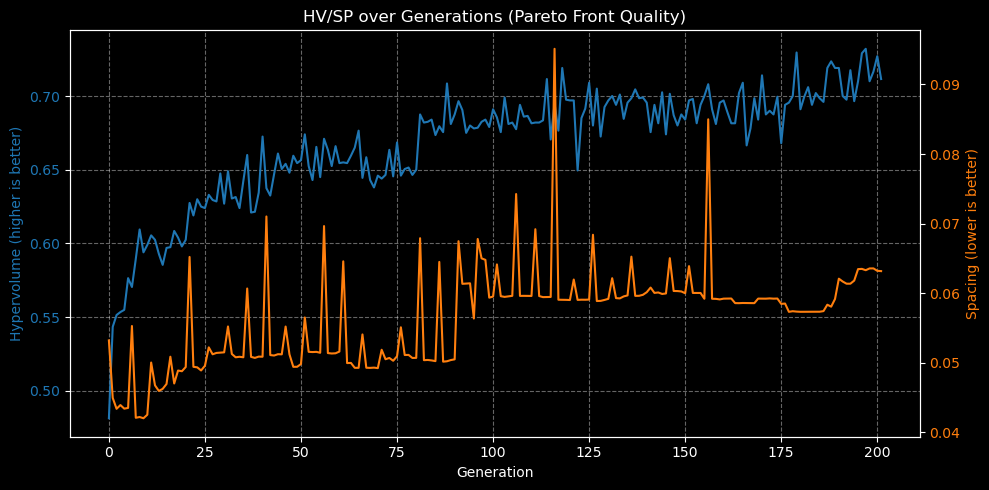


【算法性能指标】(基于固定基准的最终代结果)
Hypervolume (HV): 0.7115
Spacing (SP):     0.0632

【四维度策略优选结果】
            Ann_Return Max_Drawdown Factor_Score Num_Stocks Sharpe_Proxy
Best Sharpe      2.00%        0.24%       1.0553         30         8.45
Min Risk         2.00%        0.24%       1.0553         30         8.45
Max Return       4.21%        3.63%       2.3733         10         1.16
Max Score        4.21%        3.63%       2.3733         10         1.16

>>> 策略详情: Best Sharpe
   持仓数量: 10
   平均得分: 2.3733
Stock_Code Stock_Name            Industry  Factor_Score
    000408       藏格矿业     C26化学原料和化学制品制造业      8.221139
    300394       天孚通信 C39计算机、通信和其他电子设备制造业      8.221139
    601698       中国卫通   I63电信、广播电视和卫星传输服务      6.599777
    300274       阳光电源       C38电气机械和器材制造业      0.556112
    300476       胜宏科技 C39计算机、通信和其他电子设备制造业      0.312134
    000807       云铝股份     C32有色金属冶炼和压延加工业      0.077272
    600089       特变电工       C38电气机械和器材制造业     -0.060949
    600346       恒力股份     C26化学原料和化学制品制造业     -0.

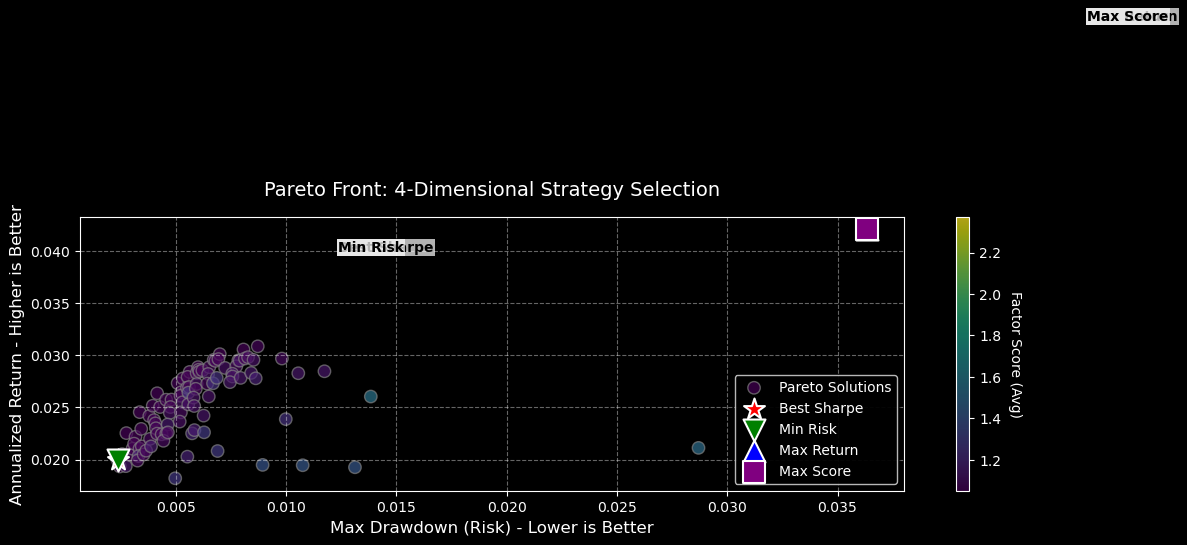


最大收益优选组合 (Top 5 by Ann_Return)
   Ann_Return Max_Drawdown Factor_Score Num_Stocks Sharpe_Proxy
98      4.21%        3.63%       2.3733         10         1.16
84      3.09%        0.87%       1.0672         30         3.54
72      3.06%        0.81%       1.0659         30         3.79
62      3.01%        0.70%       1.0645         30         4.30
82      2.98%        0.83%       1.0879         30         3.60

--------------------------------------------------
[Max Return Rank #1] Ann_Return=4.21%, MaxDD=3.63%, Score=2.3733, Num=10
Stock_Code            Industry     Score
    000408     C26化学原料和化学制品制造业  8.221139
    600346     C26化学原料和化学制品制造业 -0.062834
    000807     C32有色金属冶炼和压延加工业  0.077272
    002028       C38电气机械和器材制造业 -0.066436
    300274       C38电气机械和器材制造业  0.556112
    600089       C38电气机械和器材制造业 -0.060949
    300394 C39计算机、通信和其他电子设备制造业  8.221139
    300476 C39计算机、通信和其他电子设备制造业  0.312134
    300502 C39计算机、通信和其他电子设备制造业 -0.064053
    601698   I63电信、广播电视和卫星传输服务  6.599777

-------

In [3]:
# ==========================================
# 第四部分：主程序执行 (Main Execution)
# 功能：运行优化，输出报表
# ==========================================
if __name__ == "__main__":

    try:
        data = load_and_process_data()
        ret_mat, score_ser, sec_ser, valid_codes, sec_names, code_to_name = data

        # 2. 执行优化
        optimizer = NSGA3_Optimizer(ret_mat, score_ser, sec_ser)
        final_pop, final_objs, df_hv_sp = optimizer.run()

        # --- 【优化代码开始】生成质量指标汇总 CSV ---
        # 直接提取最后一代的指标，避免重复计算和随机误差
        final_metrics = df_hv_sp.iloc[-1]

        # 构建符合您格式要求的 DataFrame
        df_quality = pd.DataFrame([{
            "HV": final_metrics["hv"],
            "SP": final_metrics["sp"],
            "front_size": int(final_metrics["front_size"]),
            "ref_point": "1.100,1.100,1.100",  # 对应代码中固定的参考点
            "hv_samples": 2000  # 对应代码中固定的采样数
        }])

        # 导出文件
        df_quality.to_csv("NSGA-Compare/data/nsga3_front_quality_metrics.csv", index=False, encoding="utf-8-sig")
        print("已导出：nsga3_front_quality_metrics.csv (基于最终代结果)")

        # 【新增】导出每代 HV/SP
        df_hv_sp.to_csv("NSGA-Compare/data/nsga3_hv_sp_history.csv", index=False, encoding="utf-8-sig")
        print("已导出：nsga3_hv_sp_history.csv")

        # 【新增】画 HV / SP 曲线
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.plot(df_hv_sp["gen"], df_hv_sp["hv"], color="tab:blue", label="HV")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Hypervolume (higher is better)", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")
        ax1.grid(True, linestyle="--", alpha=0.4)

        ax2 = ax1.twinx()
        ax2.plot(df_hv_sp["gen"], df_hv_sp["sp"], color="tab:orange", label="SP")
        ax2.set_ylabel("Spacing (lower is better)", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")

        plt.title("HV/SP over Generations (Pareto Front Quality)")
        fig.tight_layout()
        plt.show()

        # 3. 结果整理
        df_result = pd.DataFrame({
            'Ann_Return': final_objs[:, 0],
            'Max_Drawdown': final_objs[:, 1],
            'Factor_Score': final_objs[:, 2],
            'Num_Stocks': np.sum(final_pop, axis=1)
        })

        # 计算夏普代理 (收益/回撤)
        df_result['Sharpe_Proxy'] = df_result['Ann_Return'] / (df_result['Max_Drawdown'] + 1e-6)
        df_result = df_result.sort_values('Sharpe_Proxy', ascending=False).reset_index(drop=True)

        final_metrics = df_hv_sp.iloc[-1]

        print("\n" + "=" * 40)
        print("【算法性能指标】(基于固定基准的最终代结果)")
        print(f"Hypervolume (HV): {final_metrics['hv']:.4f}")
        print(f"Spacing (SP):     {final_metrics['sp']:.4f}")
        print("=" * 40)

        # ==========================================
        # 4. 四维度优选解定位
        # ==========================================
        # 策略 A: 夏普最优 (平衡型)
        idx_sharpe = df_result['Sharpe_Proxy'].idxmax()

        # 策略 B: 最小回撤 (保守型)
        idx_min_risk = df_result['Max_Drawdown'].idxmin()

        # 策略 C: 最大收益 (激进型)
        idx_max_ret = df_result['Ann_Return'].idxmax()

        # 策略 D: 最大因子得分 (风格型) - 新增
        idx_max_score = df_result['Factor_Score'].idxmax()

        strategies = {
            "Best Sharpe": {"idx": idx_sharpe, "color": "red", "marker": "*", "file_suffix": "sharpe"},
            "Min Risk": {"idx": idx_min_risk, "color": "green", "marker": "v", "file_suffix": "min_risk"},
            "Max Return": {"idx": idx_max_ret, "color": "blue", "marker": "^", "file_suffix": "max_return"},
            "Max Score": {"idx": idx_max_score, "color": "purple", "marker": "s", "file_suffix": "max_score"}
        }

        print("\n" + "=" * 60)
        print("【四维度策略优选结果】")
        print("=" * 60)

        # 打印摘要表
        selected_indices = [meta["idx"] for meta in strategies.values()]
        selected_rows = df_result.loc[selected_indices].copy()
        selected_rows.index = strategies.keys()

        print(selected_rows[['Ann_Return', 'Max_Drawdown', 'Factor_Score', 'Num_Stocks', 'Sharpe_Proxy']].to_string(
            formatters={
                'Ann_Return': '{:.2%}'.format,
                'Max_Drawdown': '{:.2%}'.format,
                'Factor_Score': '{:.4f}'.format,
                'Num_Stocks': '{:.0f}'.format,
                'Sharpe_Proxy': '{:.2f}'.format
            }))


        # ==========================================
        # 5. 持仓详情提取与导出
        # ==========================================
        def process_portfolio(name, z_vec, scores, sectors, valid_codes, sec_names, file_suffix):
            print(f"\n>>> 策略详情: {name}")
            sel_idx = np.where(z_vec == 1)[0]

            df_holdings = pd.DataFrame({
                'Stock_Code': valid_codes[sel_idx],
                # 假设 code_to_name 在 load_data 返回值中 (需确保 load_data 返回了 code_to_name)
                # 如果没有，请注释掉下面这行
                'Stock_Name': [code_to_name.get(c, "Unknown") for c in valid_codes[sel_idx]],
                'Industry': sec_names[sectors[sel_idx]],
                'Factor_Score': scores[sel_idx]
            })

            # 统计信息
            print(f"   持仓数量: {len(df_holdings)}")
            print(f"   平均得分: {df_holdings['Factor_Score'].mean():.4f}")

            # 排序并显示前10只（按得分）
            print(df_holdings.sort_values('Factor_Score', ascending=False).head(10).to_string(index=False))
            if len(df_holdings) > 10:
                print(f"   ... (共 {len(df_holdings)} 只，完整列表已导出)")

            # 导出 CSV
            filename = f"NSGA-Compare/data/nsga3_holdings_{file_suffix}.csv"
            df_holdings.to_csv(filename, index=False, encoding="utf-8-sig")
            print(f"   [已导出]: {filename}")


        # 循环处理每个策略
        for name, meta in strategies.items():
            original_pop_idx = meta["idx"]
            best_z = final_pop[original_pop_idx]

            process_portfolio(
                name,
                best_z,
                score_ser.values,
                sec_ser.values,
                valid_codes,
                sec_names,
                meta["file_suffix"]
            )

        # ==========================================
        # 6. 可视化展现 (四点标记)
        # ==========================================
        plt.figure(figsize=(12, 8))

        # 绘制所有帕累托点 (底图)
        sc = plt.scatter(df_result['Max_Drawdown'], df_result['Ann_Return'], c=df_result['Factor_Score'],
                         cmap='viridis', s=80, alpha=0.7, edgecolors='grey', label='Pareto Solutions')
        cbar = plt.colorbar(sc)
        cbar.set_label('Factor Score (Avg)', rotation=270, labelpad=15)

        # 标记四个特殊点
        for name, meta in strategies.items():
            row = df_result.loc[meta["idx"]]
            # 绘制大点
            plt.scatter(row['Max_Drawdown'], row['Ann_Return'],
                        color=meta["color"], marker=meta["marker"], s=250,
                        label=name, zorder=10, edgecolors='white', linewidth=1.5)

            # 添加带偏移的文字标签 (防止重叠)
            # 简单的交替偏移逻辑
            y_offset = 0.02 if meta["idx"] % 2 == 0 else -0.02
            plt.text(row['Max_Drawdown'] + 0.01, row['Ann_Return'] + y_offset, name,
                     fontsize=10, fontweight='bold', color='black',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

        plt.xlabel('Max Drawdown (Risk) - Lower is Better', fontsize=12)
        plt.ylabel('Annualized Return - Higher is Better', fontsize=12)
        plt.title('Pareto Front: 4-Dimensional Strategy Selection', fontsize=14, pad=15)
        plt.legend(loc='lower right', frameon=True, framealpha=0.9, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

        # ------------------------------
        # 【新增输出】按最大收益(Ann_Return)选择 Top N 解
        # 不改变你原来的输出，只是追加一个“收益优先”榜单
        # ------------------------------
        TOP_N_BY_RETURN = 5
        PRINT_HOLDINGS_FOR_TOP_RETURN = True  # 若只想看表，不想打印持仓，改 False

        df_top_ret = (
            df_result
            .replace([np.inf, -np.inf], np.nan)
            .dropna(subset=["Ann_Return", "Max_Drawdown", "Factor_Score"])
            .sort_values("Ann_Return", ascending=False)
            .head(TOP_N_BY_RETURN)
            .copy()
        )

        print("\n" + "=" * 50)
        print(f"最大收益优选组合 (Top {TOP_N_BY_RETURN} by Ann_Return)")
        print("=" * 50)
        print(df_top_ret.to_string(formatters={
            'Ann_Return': '{:.2%}'.format,
            'Max_Drawdown': '{:.2%}'.format,
            'Factor_Score': '{:.4f}'.format,
            'Num_Stocks': '{:.0f}'.format,
            'Sharpe_Proxy': '{:.2f}'.format
        }))
        best_profile_stocks = []

        if PRINT_HOLDINGS_FOR_TOP_RETURN:
            for rank, row in enumerate(df_top_ret.itertuples(index=False), start=1):
                # 用目标向量在 final_objs 中做最近邻匹配，得到对应的 z
                #（与你下面“最佳策略持仓详情”的做法一致，确保不依赖 index 对齐）
                target = np.array([row.Ann_Return, row.Max_Drawdown, row.Factor_Score], dtype=float)
                d = np.sum((final_objs - target) ** 2, axis=1)
                idx = int(np.argmin(d))
                z = final_pop[idx]

                stocks_k = valid_codes[z == 1]
                best_profile_stocks.append(stocks_k)
                sectors_k = sec_names[sec_ser[z == 1]]
                scores_k = score_ser[z == 1]

                df_holdings_k = pd.DataFrame({
                    "Stock_Code": stocks_k,
                    "Industry": sectors_k,
                    "Score": scores_k.values
                }).sort_values("Industry")

                print("\n" + "-" * 50)
                print(f"[Max Return Rank #{rank}] Ann_Return={row.Ann_Return:.2%}, "
                      f"MaxDD={row.Max_Drawdown:.2%}, Score={row.Factor_Score:.4f}, "
                      f"Num={int(row.Num_Stocks)}")
                print(df_holdings_k.to_string(index=False))

    except Exception as e:
        print(f"程序运行出错: {e}")
        import traceback

        traceback.print_exc()

回测
======
在样本外时间验证最佳持仓组合的真实效果

In [4]:
# ==========================================
# 7. 获取四个维度的持仓代码列表 (List of Lists)
# ==========================================

# 定义提取顺序 (与您的要求一致)
# 0: 夏普最优, 1: 最大收益, 2: 最小风险, 3: 最大因子得分
# 注意：这里的 Key 必须与上面 strategies 字典中的 Key 保持一致
target_order = ["Best Sharpe", "Max Return", "Min Risk", "Max Score"]

# 初始化结果列表
optimal_stock_codes = []

print("\n" + "=" * 60)
print("【正在生成持仓代码列表...】")

for i, name in enumerate(target_order):
    # 1. 获取该策略在最终种群中的索引
    pop_idx = strategies[name]["idx"]

    # 2. 获取对应的 0-1 决策向量
    z_vec = final_pop[pop_idx]

    # 3. 提取为 1 的位置，并映射回股票代码
    sel_idx = np.where(z_vec == 1)[0]
    codes_list = valid_codes[sel_idx].tolist()  # 转为 Python list

    # 4. 存入大列表
    optimal_stock_codes.append(codes_list)

    print(f"  列表索引 [{i}] - {name}: 提取了 {len(codes_list)} 只股票代码")

print("=" * 60)


【正在生成持仓代码列表...】
  列表索引 [0] - Best Sharpe: 提取了 10 只股票代码
  列表索引 [1] - Max Return: 提取了 29 只股票代码
  列表索引 [2] - Min Risk: 提取了 10 只股票代码
  列表索引 [3] - Max Score: 提取了 29 只股票代码



==================== 正在回测: Best Sharpe ====================
正在获取 10 只股票数据...
[1/10] 000408 成功
[2/10] 000807 成功
[3/10] 002028 成功
[4/10] 300274 成功
[5/10] 300394 成功
[6/10] 300476 成功
[7/10] 300502 成功
[8/10] 600089 成功
[9/10] 600346 成功
[10/10] 601698 成功


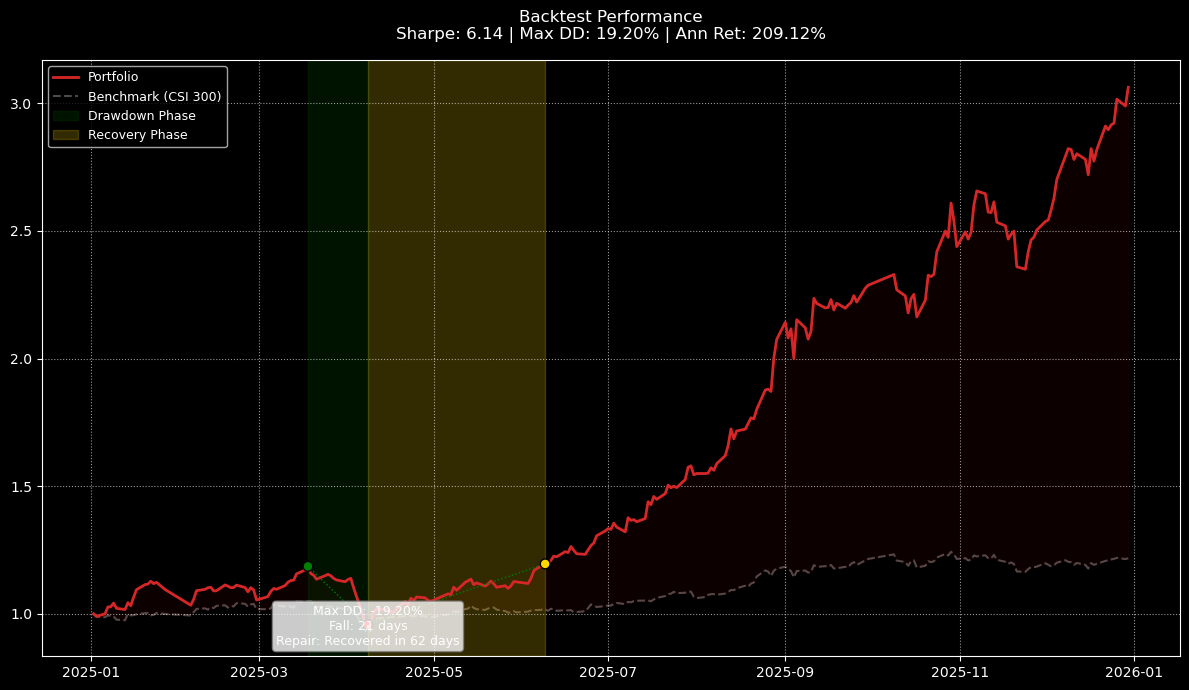


==================== 正在回测: Max Return ====================
正在获取 29 只股票数据...
[1/29] 000408 成功
[2/29] 000617 成功
[3/29] 000768 成功
[4/29] 000807 成功
[5/29] 000999 成功
[6/29] 002311 成功
[7/29] 002625 成功
[8/29] 002920 成功
[9/29] 300308 成功
[10/29] 300394 成功
[11/29] 300476 成功
[12/29] 300502 成功
[13/29] 300782 成功
[14/29] 600036 成功
[15/29] 600089 成功
[16/29] 600115 成功
[17/29] 600183 成功
[18/29] 600219 成功
[19/29] 600346 成功
[20/29] 600426 成功
[21/29] 601066 成功
[22/29] 601186 成功
[23/29] 601319 成功
[24/29] 601390 成功
[25/29] 601601 成功
[26/29] 601607 成功
[27/29] 601698 成功
[28/29] 601808 成功
[29/29] 601857 成功


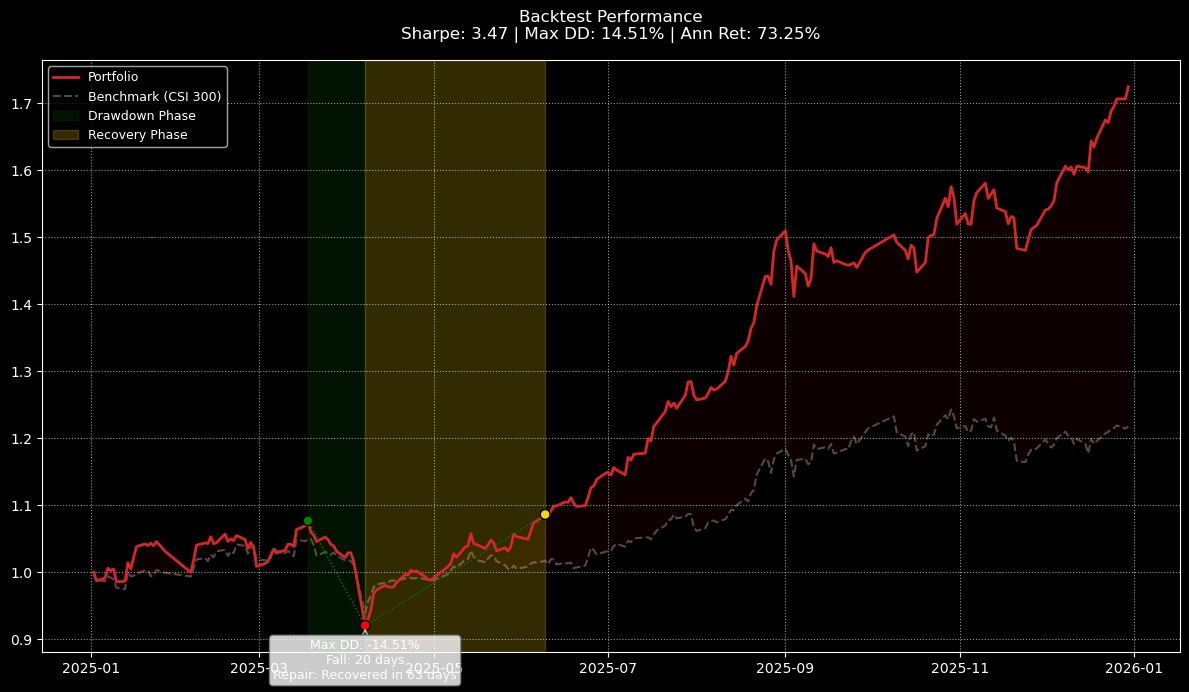


==================== 正在回测: Min Risk ====================
正在获取 10 只股票数据...
[1/10] 000408 成功
[2/10] 000807 成功
[3/10] 002028 成功
[4/10] 300274 成功
[5/10] 300394 成功
[6/10] 300476 成功
[7/10] 300502 成功
[8/10] 600089 成功
[9/10] 600346 成功
[10/10] 601698 成功


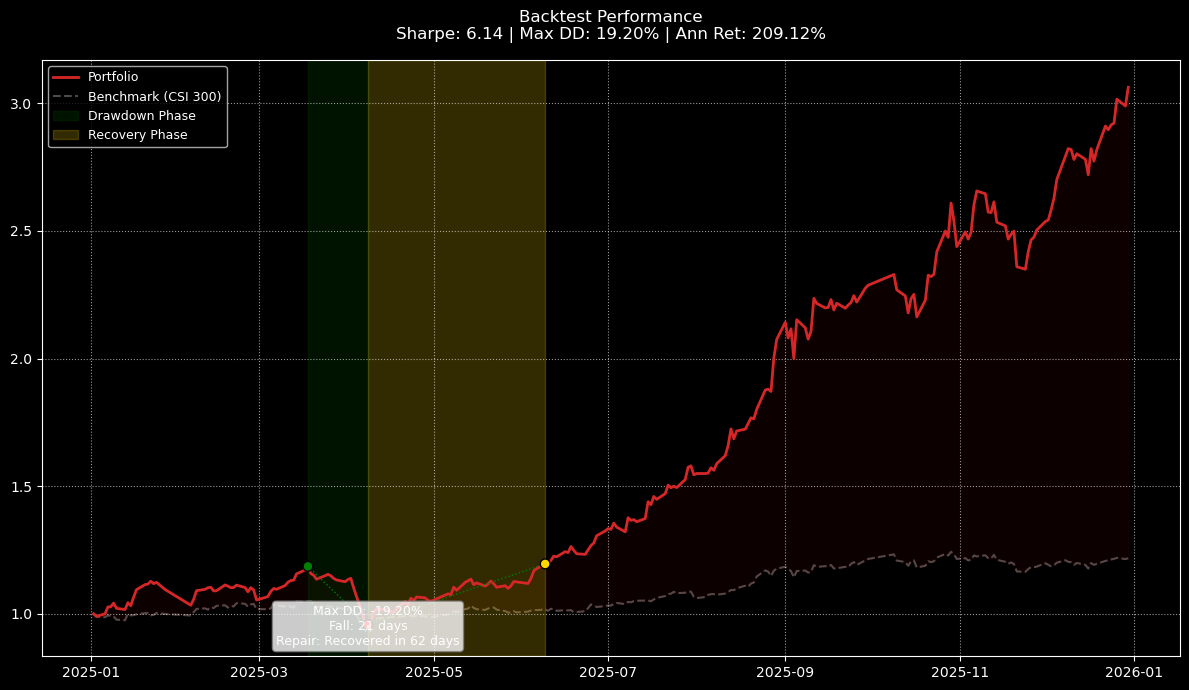


==================== 正在回测: Max Score ====================
正在获取 29 只股票数据...
[1/29] 000408 成功
[2/29] 000617 成功
[3/29] 000768 成功
[4/29] 000807 成功
[5/29] 000999 成功
[6/29] 002311 成功
[7/29] 002625 成功
[8/29] 002920 成功
[9/29] 300308 成功
[10/29] 300394 成功
[11/29] 300476 成功
[12/29] 300502 成功
[13/29] 300782 成功
[14/29] 600036 成功
[15/29] 600089 成功
[16/29] 600115 成功
[17/29] 600183 成功
[18/29] 600219 成功
[19/29] 600346 成功
[20/29] 600426 成功
[21/29] 601066 成功
[22/29] 601186 成功
[23/29] 601319 成功
[24/29] 601390 成功
[25/29] 601601 成功
[26/29] 601607 成功
[27/29] 601698 成功
[28/29] 601808 成功
[29/29] 601857 成功


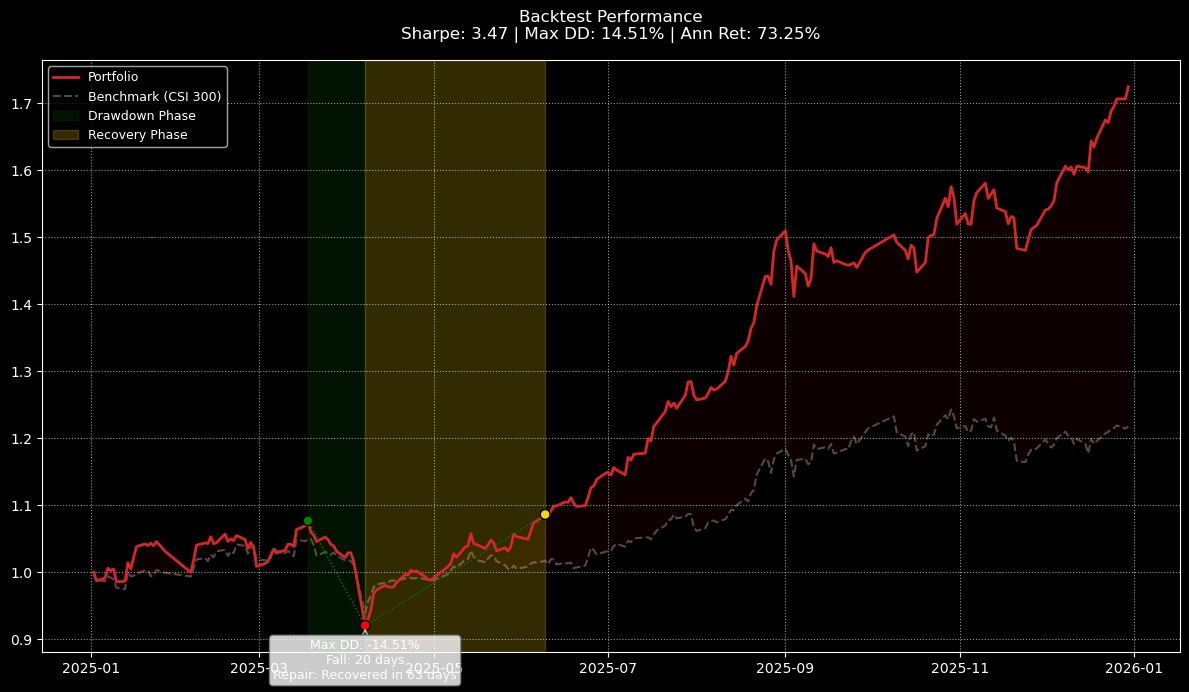


==================== 正在计算基准: CSI300 ====================
基准指标计算完成，已加入对比表。

【所有策略样本外回测结果对比】
                    Total Return  Annual Return  Sharpe Ratio  Max Drawdown DD Start Date DD Valley Date DD Recovery Date  Is Recovered  Recovery Days
Strategy                                                                                                                                              
Benchmark (CSI300)      0.217485       0.219472      1.334347      0.104916    2025-03-19     2025-04-07       2025-07-11          True             95
Best Sharpe             2.062671       2.091212      6.139860      0.192047    2025-03-18     2025-04-08       2025-06-09          True             62
Max Return              0.724725       0.732534      3.467588      0.145139    2025-03-18     2025-04-07       2025-06-09          True             63
Min Risk                2.062671       2.091212      6.139860      0.192047    2025-03-18     2025-04-08       2025-06-09          True             62
Ma

In [7]:

from backtesting import AkShareBacktestEngine
from pathlib import Path
import re
import akshare as ak

output_dir = Path("NSGA-Compare/backtest")
plot_dir = output_dir / "backtest_plots"
output_dir.mkdir(parents=True, exist_ok=True)
plot_dir.mkdir(parents=True, exist_ok=True)

# 1. 初始化回测引擎
engine = AkShareBacktestEngine(risk_free_rate=0.02)

# 2. 准备一个列表来存储所有策略的回测结果
all_metrics = []

# 3. 循环遍历每个策略的持仓列表
# target_order 在上一个单元格中已经定义
for i, stock_list in enumerate(optimal_stock_codes):
    strategy_name = target_order[i]
    print(f"\n{'=' * 20} 正在回测: {strategy_name} {'=' * 20}")

    # 清理股票代码 (与您原来的逻辑保持一致)
    stocks_to_backtest = (
        pd.Series(stock_list, dtype="string")
        .astype(str).str.strip()
        .str.replace(r"\.SZ$|\.SH$", "", regex=True)
        .str.zfill(6)
        .tolist()
    )

    # 检查股票列表是否为空
    if not stocks_to_backtest:
        print(f"策略 '{strategy_name}' 持仓为空，跳过回测。")
        continue

    safe_name = re.sub(r"[^A-Za-z0-9._-]+", "_", strategy_name)
    plot_path = plot_dir / f"backtest_{safe_name}.png"

    # 4. 执行回测
    # 注意：这里使用了样本外的时间段 (2022-12-01 到 2024-11-30)
    # 这个时间段在您的优化周期 (2024-12-02 开始) 之前，是真实有效的样本外测试
    metrics = engine.run(
        stock_codes=stocks_to_backtest,
        start_date="2025-01-01",
        end_date="2025-12-30",
        plot_path=plot_path
    )

    # 5. 存储结果，并添加策略名称
    metrics['Strategy'] = strategy_name
    all_metrics.append(metrics)
# ==========================================
# 【新增代码】获取 CSI300 基准并计算指标
# ==========================================
try:

    print(f"\n{'=' * 20} 正在计算基准: CSI300 {'=' * 20}")

    # 定义与回测一致的日期范围 (格式转换为 YYYYMMDD 以适配 akshare)
    s_date_str = "20250101"
    e_date_str = "20251230"

    # 获取沪深300指数数据
    df_bench = ak.index_zh_a_hist(symbol="000300", period="daily", start_date=s_date_str, end_date=e_date_str)

    if not df_bench.empty:
        df_bench['日期'] = pd.to_datetime(df_bench['日期'])
        df_bench.set_index('日期', inplace=True)

        # 计算净值 (归一化为 1.0)
        bench_nav = df_bench['收盘'] / df_bench['收盘'].iloc[0]

        # 使用 engine 内部的方法计算指标 (确保计算口径与策略一致)
        bench_metrics = engine.calculate_metrics(bench_nav)

        # 标记名称
        bench_metrics['Strategy'] = 'Benchmark (CSI300)'

        # 将基准指标插入到结果列表的第一个位置
        all_metrics.insert(0, bench_metrics)
        print("基准指标计算完成，已加入对比表。")
    else:
        print("未获取到 CSI300 数据，跳过基准对比。")

except Exception as e:
    print(f"基准计算失败: {e}")

# 6. 将所有结果合并成一个 DataFrame 并展示
if all_metrics:
    df_all_metrics = pd.DataFrame(all_metrics).set_index('Strategy')

    csv_path = output_dir / "backtest_metrics.csv"
    df_all_metrics.to_csv(csv_path, encoding="utf-8-sig")

    print("\n" + "=" * 60)
    print("【所有策略样本外回测结果对比】")
    print("=" * 60)
    print(df_all_metrics.to_string())
else:
    print("没有可用的回测结果。")

单独验证score分数与一年后收益的相关性
== == =

正在获取 30 只股票数据...
[1/30] 002384 成功
[2/30] 002648 成功
[3/30] 002920 成功
[4/30] 300308 成功
[5/30] 300316 成功
[6/30] 000301 成功
[7/30] 000425 成功
[8/30] 600029 成功
[9/30] 600031 成功
[10/30] 600089 成功
[11/30] 600183 成功
[12/30] 600522 成功
[13/30] 600547 成功
[14/30] 600570 成功
[15/30] 601006 成功
[16/30] 601066 成功
[17/30] 601100 成功
[18/30] 601698 成功
[19/30] 601899 成功
[20/30] 601995 成功
[21/30] 603993 成功
[22/30] 605117 成功
[23/30] 000625 成功
[24/30] 688012 成功
[25/30] 688082 成功
[26/30] 688187 成功
[27/30] 688223 成功
[28/30] 000792 成功
[29/30] 000876 成功
[30/30] 000977 成功


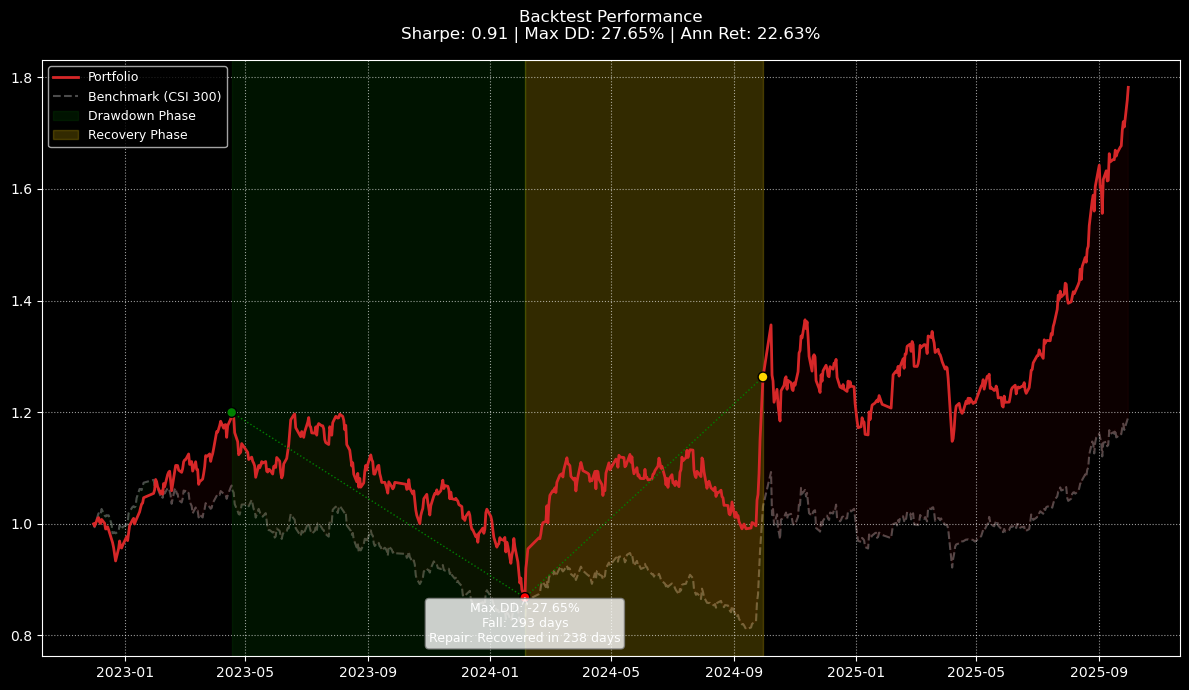

In [16]:
stocks = (
    pd.Series(best_profile_stocks[:30])
    .astype(str).str.strip()
    .str.replace(r"\.SZ$|\.SH$", "", regex=True)
    .str.zfill(6)
)

engine = AkShareBacktestEngine(risk_free_rate=0.02)  # create an instance
metrics = engine.run(
    stock_codes=stocks.tolist(),  # optional: pass a plain list instead of a Series
    start_date="2022-12-01",
    end_date="2025-10-01",
)

单独验证score分数与一年后收益的相关性
=====
额外证明了score的有效设计

对比试验，使用哪些其他算法，未改进的
======